### Simple GAN 

May 2, 2022

_Version 3: Tuning 1) Epochs, 2) Coding_Size_

In [1]:
#!pip install nibabel
import nibabel as nib
import numpy as np
import glob
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

In [2]:
df = pd.read_csv('/project/ds6050-soa2wg/team_lambda_II/ASD_DSM_CasesvsControls.csv', sep = ',')

In [3]:
df

,FILE_ID,DX_GROUP,DSM_IV_TR,SEX,DX_Control,DX_DSM,SEX_,PATH
0,Pitt_0050005,1,1,2,Autism,Autism,Female,/project/ds6050-soa2wg/team_lambda_II/Outputs/...
1,Pitt_0050006,1,1,1,Autism,Autism,Male,/project/ds6050-soa2wg/team_lambda_II/Outputs/...
2,Pitt_0050007,1,1,1,Autism,Autism,Male,/project/ds6050-soa2wg/team_lambda_II/Outputs/...
3,Pitt_0050011,1,1,1,Autism,Autism,Male,/project/ds6050-soa2wg/team_lambda_II/Outputs/...
4,Pitt_0050014,1,1,1,Autism,Autism,Male,/project/ds6050-soa2wg/team_lambda_II/Outputs/...
...,...,...,...,...,...,...,...,...
386,UCLA_1_0051280,2,0,1,Control,Control,Male,/project/ds6050-soa2wg/team_lambda_II/Outputs/...
387,UCLA_1_0051281,2,0,1,Control,Control,Male,/project/ds6050-soa2wg/team_lambda_II/Outputs/...
388,UCLA_1_0051282,2,0,2,Control,Control,Female,/project/ds6050-soa2wg/team_lambda_II/Outputs/...
389,UCLA_2_0051303,2,0,2,Control,Control,Female,/project/ds6050-soa2wg/team_lambda_II/Outputs/...


In [4]:
# obtain paths for all images
images_paths_f_case = list(df.query("SEX_ == 'Female' & DX_Control == 'Autism'")['PATH'])
images_paths_f_control = list(df.query("SEX_ == 'Female' & DX_Control == 'Control'")['PATH'])
images_paths_m_case = list(df.query("SEX_ == 'Male' & DX_Control == 'Autism'")['PATH'])
images_paths_m_control = list(df.query("SEX_ == 'Male' & DX_Control == 'Control'")['PATH'])

total_cases = len(images_paths_f_case) + len(images_paths_m_case)
total_controls = len(images_paths_f_control ) + len(images_paths_m_control)
# print out number of participants per category
print('There are {} female cases'.format(str(len(images_paths_f_case))))
print('---------------------------------------')
print('There are {} female controls'.format(str(len(images_paths_f_control))))
print('---------------------------------------')
print('There are {} male cases'.format(str(len(images_paths_m_case))))
print('---------------------------------------')
print('There are {} male controls'.format(str(len(images_paths_m_control))))
print('---------------------------------------')
print(f'There are {total_cases} total cases and {total_controls} total controls! {total_controls + total_cases} participants in total')
# make one giant list
#images_paths = images_paths_f_case  + images_paths_f_control + images_paths_m_case + images_paths_m_control

# positive cases only
#images_paths = images_paths_f_case + images_paths_m_case

# female only (testing purposes)
#images_paths = images_paths_f_case

# male only (testing purposes)
#images_paths = images_paths_m_case

# female controls 
images_paths = images_paths_f_control

num_im = len(images_paths)
image_array = []

There are 22 female cases
---------------------------------------
There are 61 female controls
---------------------------------------
There are 124 male cases
---------------------------------------
There are 184 male controls
---------------------------------------
There are 146 total cases and 245 total controls! 391 participants in total


In [5]:
final_list = [] # create image array from paths
for path in images_paths:
    try: 
        img = nib.load(path)
        image_data = img.get_fdata()
        image_array.append(image_data)
        final_list.append(path)
    except:
        continue
    
image_array = np.asarray(image_array).astype('float32')

In [6]:
image_array.shape

(61, 61, 73, 61)

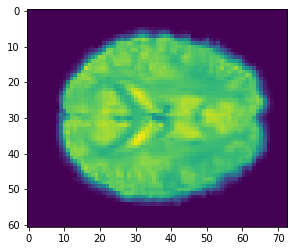

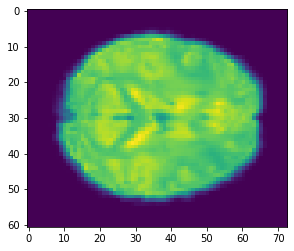

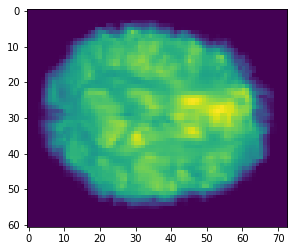

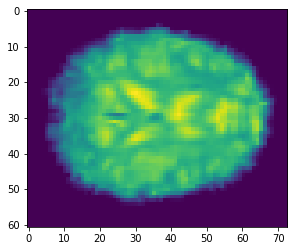

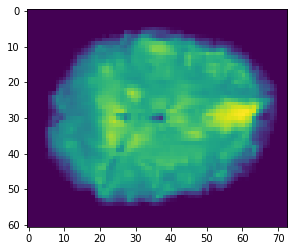

In [7]:
# Visualize 5 of the 391 images
for i in image_array[:5]: 
    plt.imshow(i[:,:,30])
    plt.show()

In [8]:
# #??? Ask Chelsea about this line of code. How is this phenotype data? 
# pheno = df[['FILE_ID', 'DX_GROUP']]
# pheno_array = np.array(pheno['DX_GROUP'])
# pheno_array = np.where(pheno_array == 2, 0, pheno_array) # This is a function to replace 2 with 0
# # distribution
# df['DX_GROUP'].value_counts()

# I think she means for this to be y label data right?
y = df[['FILE_ID', 'DSM_IV_TR', 'SEX_']] # 1 means Autism, 0 means Control
#y_array = np.array(y['DSM_IV_TR'])

#positive only 
#y_array = np.array(y.query("DSM_IV_TR == 1")["DSM_IV_TR"])

# female only (testing purposes)
#y_array = np.array(y.query("DSM_IV_TR == 1 & SEX_ == 'Female'")["DSM_IV_TR"])

# male only (testing purposes)
#y_array = np.array(y.query("DSM_IV_TR == 1 & SEX_ == 'Male'")["DSM_IV_TR"])

# female controls 
y_array = np.array(y.query("DSM_IV_TR == 0 & SEX_ == 'Female'")["DSM_IV_TR"])

In [9]:
y_array

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [10]:
#x_train, x_test, y_train, y_test = train_test_split(image_array, pheno_array, test_size = 0.25, random_state = 44)
x_train, x_test, y_train, y_test = train_test_split(image_array, y_array, test_size = 0.25, random_state = 44)

In [11]:
x_train.shape

(45, 61, 73, 61)

In [12]:
# Checking imbalance of training set. Below is how you do value counts for np array. 
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[ 0, 45]])

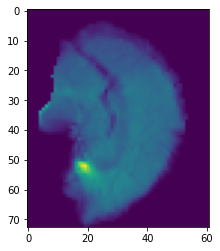

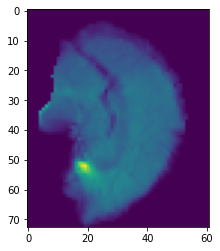

In [13]:
# first attempt at plotting 
#plt.imshow(x_train[:,:,30])
#TypeError: Invalid shape (293, 61, 61) for image data

#borrowing my other code for plotting
for i in x_train[:1]: 
    plt.imshow(i[30,:,:])
    plt.show()
    
# this code also works
plt.imshow(x_train[0][30])
plt.show()

In [14]:
# def train_preprocessing(volume, label):
#     """Process training data by rotating and adding a channel."""
#     # Rotate volume
#     volume = rotate(volume)
#     volume = tf.expand_dims(volume, axis=3) #??? Is the extra channel by how much the image was rotated? Ask Dylan.
#     return volume, label

# def validation_preprocessing(volume, label):
#     """Process validation data by only adding a channel."""
#     volume = tf.expand_dims(volume, axis=3)
#     return volume, label

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1 #return the integer of the division 
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image[30,:,:])
        #plt.imshow(image, cmap="binary")
        plt.axis("off")

In [15]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train)) # This is cool, double-check the documentation for this??? 
validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test)) #??? Should we have equal number of each class in our training data? 

batch_size = 16
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train)) # ??? shuffle dubplicates right? Or does it only shuffle? Double-check
#     .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE) # ??? I thought prefetch was for speed purposes. What is this tf.data.AUTOTUNE. Double-check. 
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_test))
#    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

2022-05-02 21:46:03.101679: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-02 21:46:03.101714: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (udc-an33-17c1): /proc/driver/nvidia/version does not exist
2022-05-02 21:46:03.104466: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# GAN

Cross section 30

#### 3000 Coding_Size and 500 Epochs

In [16]:
codings_size = 3000 # What is this???
# Apparently, latent representations = coding 
# !!! Let's iterate through values of this to tst what effect it has 
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(61 * 73 * 61, activation="sigmoid"),
    keras.layers.Reshape([61, 73, 61])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[61, 73, 61]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [17]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [18]:
batch_size = 32
#batch_size = 1 # Never finishes 
#batch_size = 150 # Errors out 
#x_train = tf.cast(x_train,tf.float32) # This was not in the texbook code. Test the effect of this 
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [19]:
#@tf.function
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs)) # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            #print(noise)
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            #print(X_fake_and_real)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            #print(y1)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1) #??? How does train_on_batch differ from fit? 
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        #plot_multiple_images(generated_images, 8) # not shown 
        #plot_multiple_images(generated_images, 4) # not shown 
        #plt.show() # not shown
#         if epoch == 0: 
#             plot_multiple_images(generated_images, 8) # not shown 
#             plt.show() # not shown
#         elif (epoch+1)%50 == 0: 
#             plot_multiple_images(generated_images, 8) # not shown 
#             plt.show() # not shown
    #return generated_images # Not shown. Trying to figure out where to put this 

In [20]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=500)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

In [21]:
# trying a different batch_size 
real_size = 61
batch_size = 184 - real_size
codings_size = 3000
noise = tf.random.normal(shape=[batch_size, codings_size])
#print(noise)
GAN = generator(noise)

In [22]:
import numpy as np
import pickle
from pathlib import Path

path = Path('/project/ds6050-soa2wg/team_lambda_II/').expanduser()
path.mkdir(parents=True, exist_ok=True)

In [23]:
# using save (to npy), savez (to npz)
np.save(path/'gan_neg_female_ep500_cs3000_si{}'.format(batch_size), GAN)

## using loading npy, npz files
gan_loaded = np.load(path/'gan_neg_female_ep500_cs3000_si{}.npy'.format(batch_size))

In [24]:
gan_loaded.shape

(123, 61, 73, 61)

In [25]:
print(GAN == gan_loaded)

tf.Tensor(
[[[[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  ...

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   